In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Set environment variables
import os

os.environ["SCAL_TYPE"] = "complex"
os.environ["PRECISION"] = "double"
os.environ["MY_NUMBA_TARGET"] = "numba"
 
# Add cle_fun to PYTHON_PATH
import sys
sys.path.append("../../clonscal")

In [2]:
from simulation.config import Config
from simulation.cl_simulation import ComplexLangevinSimulation
from src.utils import noise_kernel, evolve_kernel, mexican_hat_kernel_real, KernelBridge
from src.obs_kernels import n_moment_kernel
from tqdm import tqdm


def run_simulation(config, n_steps = int(1e4)):
    # define simulation parameters

    # create simulation instance
    sim = ComplexLangevinSimulation(config)

    # define kernel bridge with kernels defining the theory
    kernel_br = KernelBridge(sim, [noise_kernel, evolve_kernel, mexican_hat_kernel_real], const_param={})

    # register observable
    sim.register_observable('1_moment', obs_kernel=n_moment_kernel, const_params={'order': 1}, langevin_history=True)

    # init arguments
    args = kernel_br.get_current_params()

    # start the loop 
    for k in tqdm(range(n_steps)):
        sim.update_noise(noise_kernel, *args[noise_kernel].values())
        sim.update_drift(mexican_hat_kernel_real, *args[mexican_hat_kernel_real].values())
        args = kernel_br.get_current_params()
        sim.set_apative_stepsize()
        sim.update_field(evolve_kernel, *args[evolve_kernel].values())
        sim.swap()

        if np.any(np.isnan(sim.phi0)): print('break'); break
        if sim.langevin_time > 5: sim.compute('1_moment')

    sim.finish()
    return sim

Using double precision
Using C^1
Using Numba


100%|██████████| 10000/10000 [00:09<00:00, 1021.51it/s]


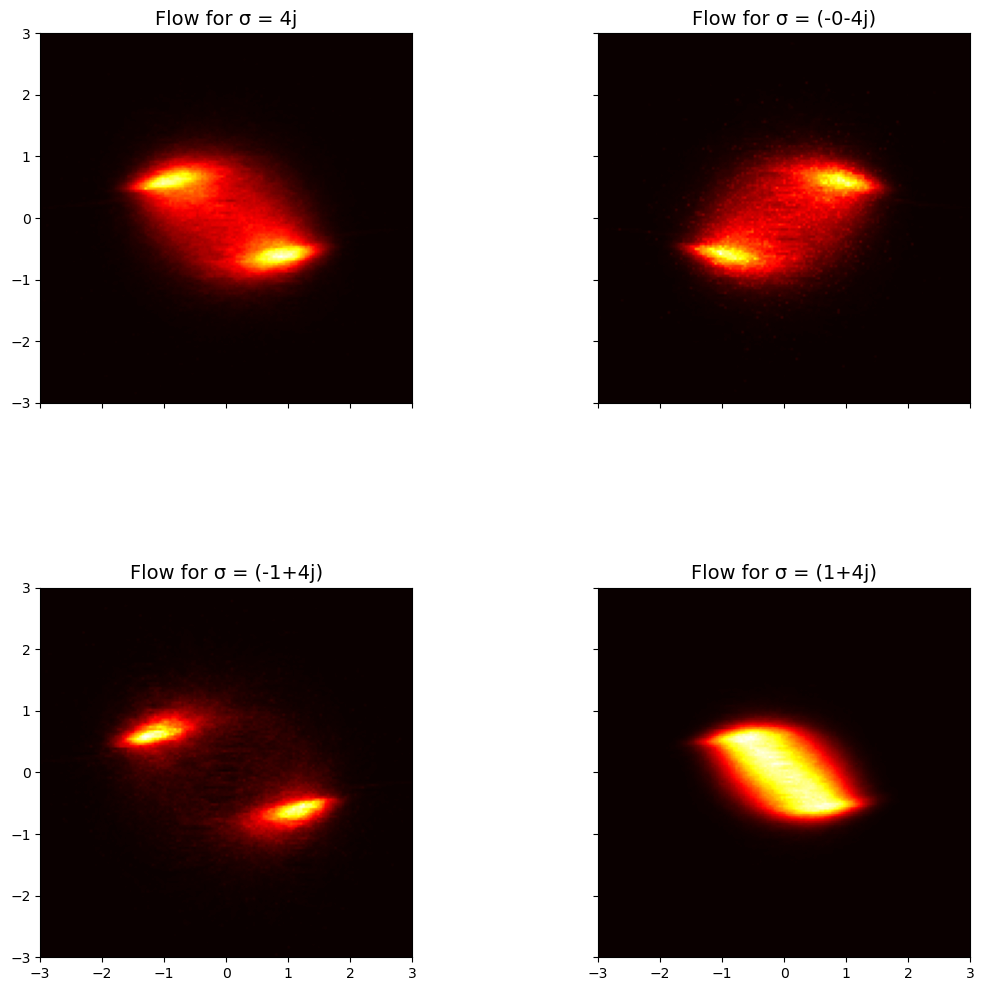

In [7]:
interaction = 12
sigma_values = 4*np.array([np.cos(angle+0.005) + 1j*np.sin(angle+0.005) for angle in np.linspace(0, 2*np.pi, 5)[:-1]])  # Different sigma values
sigma_values = [4j, -4j, 4j-1, 4j+1]

# Set up the subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 12), sharex=True, sharey=True)
axes = axes.flatten()
fig.subplots_adjust(hspace=0.5, wspace=0.5)  # Adjust spacing between subplots


for sigma, ax in zip(sigma_values, axes):
    config = Config(dims=[1000], dt = 1e-3, mass_real = sigma, interaction=6*2)
    sim = run_simulation(config, n_steps=int(1e4))
    data = sim.trackers['1_moment'].history.flatten()

    magnitudes = np.abs(data)
    data = data[magnitudes <= 10]   
    real_parts, imag_parts = data.real, data.imag
    bins = 500
    heatmap, xedges, yedges = np.histogram2d(real_parts, imag_parts, bins=bins)

    # Plot the heatmap
    ax.imshow(
        heatmap.T,
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
        origin='lower',
        cmap='hot',
        aspect='auto',
    )
    ax.set_title(f'Flow for σ = {np.round(sigma)}', fontsize=14)
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
plt.show()
